In [1]:
import pandas as pd
import numpy as np

import torch

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
data_path = "./data/train.csv"

group = [
    [34, 40, 42, 41, 4, 10, 11, 12],
    [35, 6, 48, 27, 57, 8, 25, 56, 26, 55, 47, 13, 53, 18, 7, 17, 46],
    [31, 33, 9, 3, 1, 32],
    [29, 38, 43, 58, 15, 22, 39, 54, 23, 44, 45, 37, 52, 2, 14],
    [21, 19, 50, 49, 20, 51, 30, 36, 28, 59, 5, 60, 16, 24]
]

In [3]:
data = pd.read_csv(data_path, parse_dates = ["date_time"])

data["time_idx"] = 0
data["month"] = 0
data["energy_group"] = 0
data["Week"] = 0
data["24Hour"] = 0

data.loc[data["num"].isin(group[0]), "energy_group"] = str(1)
data.loc[data["num"].isin(group[1]), "energy_group"] = str(2)
data.loc[data["num"].isin(group[2]), "energy_group"] = str(3)
data.loc[data["num"].isin(group[3]), "energy_group"] = str(4)
data.loc[data["num"].isin(group[4]), "energy_group"] = str(5)

data.loc[data["date_time"].dt.month == 6, 'month'] = 0
data.loc[data["date_time"].dt.month == 7, 'month'] = 30
data.loc[data["date_time"].dt.month == 8, 'month'] = 61

data["time_idx"] = data["date_time"].dt.hour + data["date_time"].dt.day * (24) + data["month"] * 24
data["time_idx"] = data["time_idx"] - min(data["time_idx"])

data["Week"] = (data["date_time"].dt.day + data["month"]) % 7
data["24Hour"] = data["date_time"].dt.hour

data = data.drop("month",axis='columns')

data.rename(columns = {'전력사용량(kWh)' : 'kWH', '기온(°C)' : 'C', '풍속(m/s)' : 'm/s', '습도(%)' : 'wet', '강수량(mm)' : 'mm','일조(hr)' : 'hr', '비전기냉방설비운영' : "non_electric_aircondition", "태양광보유" : "sunlight"}, inplace = True)

data = data.astype({'non_electric_aircondition' : int, 'sunlight' : int})
data['num'] = data['num'].apply(str)
data['Week'] = data['Week'].apply(str)
data['24Hour'] = data['24Hour'].apply(str)

data.to_csv("test.csv", mode='w')

data.head()

,num,date_time,kWH,C,m/s,wet,mm,hr,non_electric_aircondition,sunlight,time_idx,energy_group,Week,24Hour
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0,0,0,3,1,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0,0,1,3,1,1
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0,0,2,3,1,2
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0,0,3,3,1,3
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0,0,4,3,1,4


In [4]:
data_bag = [
    data.loc[data["energy_group"] == "1"].copy(),
    data.loc[data["energy_group"] == "2"].copy(),
    data.loc[data["energy_group"] == "3"].copy(),
    data.loc[data["energy_group"] == "4"].copy(),
    data.loc[data["energy_group"] == "5"].copy()
]

models = []

In [5]:
for data in data_bag:
    max_prediction_length = 24
    max_encoder_length = 168
    training_cutoff = data["time_idx"].max() - max_prediction_length

    training = TimeSeriesDataSet(
        data[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="kWH",
        group_ids=["num"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        static_categoricals=["num", "energy_group"],
        static_reals=["non_electric_aircondition", "sunlight"],
        time_varying_known_categoricals=["Week", "24Hour"],
        time_varying_known_reals=["C", "m/s", "wet", "mm", "hr", "time_idx"],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=["kWH"],
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

    # create validation set (predict=True) which means to predict the last max_prediction_length points in time
    # for each series
    validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

    # create dataloaders for model
    batch_size = 32  # set this between 32 to 128
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    # configure network and trainer
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=30, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

    trainer = pl.Trainer(
        max_epochs=500,
        gpus=1,
        weights_summary="top",
        gradient_clip_val=0.14,
        limit_train_batches=30, 
        callbacks=[lr_logger, early_stop_callback],
        logger=logger,
    )


    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.01,
        hidden_size=64,
        attention_head_size=4,
        dropout=0.15,
        hidden_continuous_size=8,
        output_size=7,
        loss=QuantileLoss(),
        log_interval=0,
        reduce_on_plateau_patience=4,
    )

    # fit network
    trainer.fit(
        tft,
        train_dataloader=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    # load the best model according to the validation loss
    # (given that we use early stopping, this is not necessarily the last epoch)
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

    # raw predictions are a dictionary from which all kind of information including quantiles can be extracted
    raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

    models.append([best_tft, raw_predictions, x])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 292   
3  | prescalers                         | ModuleDict                      | 208   
4  | static_variable_selection          | VariableSelectionNetwork        | 9.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 15.2 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 13.3 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedR

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\Eunchan\anaconda3\envs\torch1\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:   0%|          | 0/31 [00:00<?, ?it/s] 

C:\Users\Eunchan\anaconda3\envs\torch1\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 44: 100%|██████████| 31/31 [00:04<00:00,  6.30it/s, loss=47.8, v_num=0, val_loss=49.90, train_loss_step=50.60, train_loss_epoch=46.60]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 388   
3  | prescalers                         | ModuleDict                      | 208   
4  | static_variable_selection          | VariableSelectionNetwork        | 9.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 15.2 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 13.3 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedR

Epoch 0:   0%|          | 0/31 [00:00<?, ?it/s] 

C:\Users\Eunchan\anaconda3\envs\torch1\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\Users\Eunchan\anaconda3\envs\torch1\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 52: 100%|██████████| 31/31 [00:04<00:00,  6.75it/s, loss=28.2, v_num=1, val_loss=156.0, train_loss_step=27.30, train_loss_epoch=28.50]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 276   
3  | prescalers                         | ModuleDict                      | 208   
4  | static_variable_selection          | VariableSelectionNetwork        | 9.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 15.2 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 13.3 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedR

Epoch 0:   0%|          | 0/31 [00:00<?, ?it/s] 

C:\Users\Eunchan\anaconda3\envs\torch1\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\Users\Eunchan\anaconda3\envs\torch1\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 39: 100%|██████████| 31/31 [00:04<00:00,  6.86it/s, loss=8.65, v_num=2, val_loss=17.60, train_loss_step=11.00, train_loss_epoch=8.470]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 357   
3  | prescalers                         | ModuleDict                      | 208   
4  | static_variable_selection          | VariableSelectionNetwork        | 9.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 15.2 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 13.3 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedR

Epoch 0:   0%|          | 0/31 [00:00<?, ?it/s] 

C:\Users\Eunchan\anaconda3\envs\torch1\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\Users\Eunchan\anaconda3\envs\torch1\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 39: 100%|██████████| 31/31 [00:04<00:00,  6.86it/s, loss=32.5, v_num=3, val_loss=135.0, train_loss_step=28.70, train_loss_epoch=32.40]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 350   
3  | prescalers                         | ModuleDict                      | 208   
4  | static_variable_selection          | VariableSelectionNetwork        | 9.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 15.2 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 13.3 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedR

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\Eunchan\anaconda3\envs\torch1\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:   0%|          | 0/31 [00:00<?, ?it/s] 

C:\Users\Eunchan\anaconda3\envs\torch1\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 43: 100%|██████████| 31/31 [00:04<00:00,  6.87it/s, loss=27.9, v_num=4, val_loss=41.30, train_loss_step=23.70, train_loss_epoch=27.60]


---------------------- 절취선 ------------------------
---------------------- 절취선 ------------------------


C:\Users\Eunchan\anaconda3\envs\torch1\lib\site-packages\pytorch_forecasting\models\base_model.py:663: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


---------------------- 절취선 ------------------------
---------------------- 절취선 ------------------------
---------------------- 절취선 ------------------------


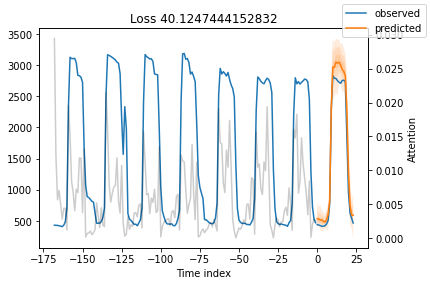

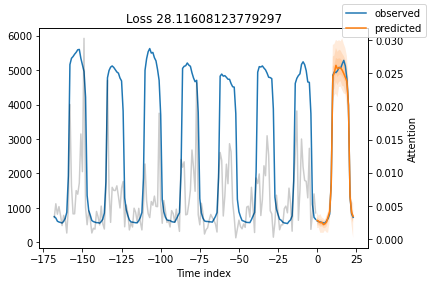

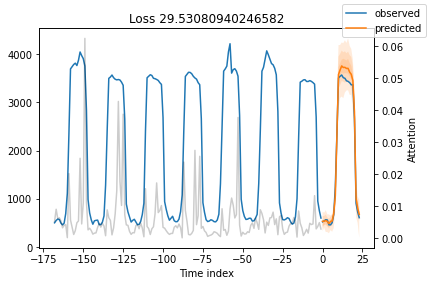

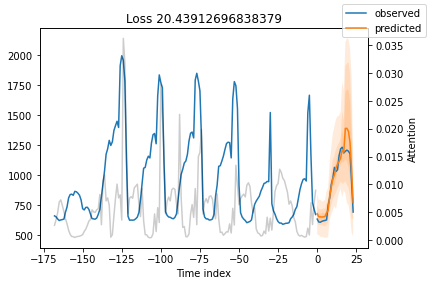

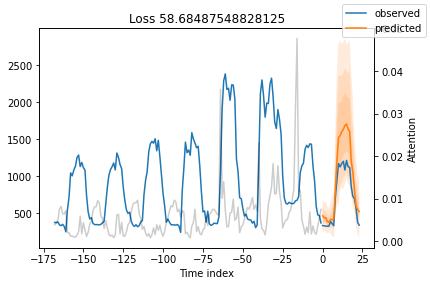

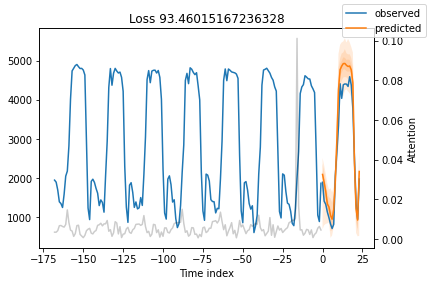

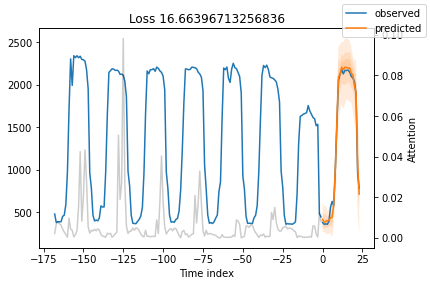

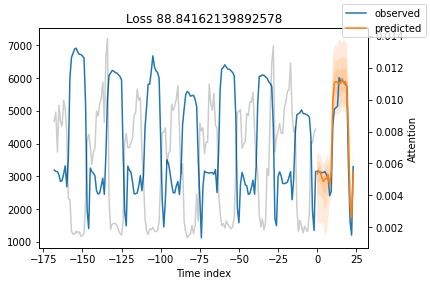

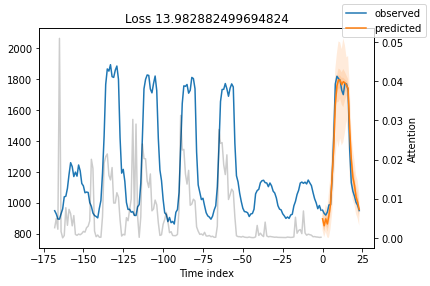

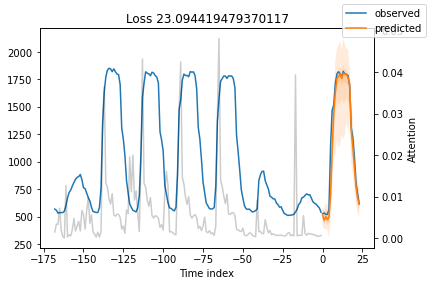

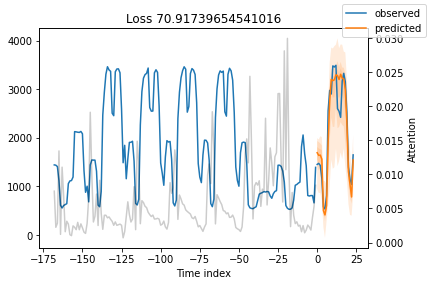

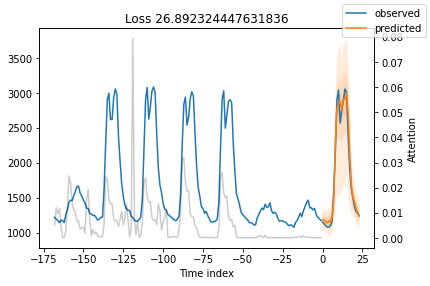

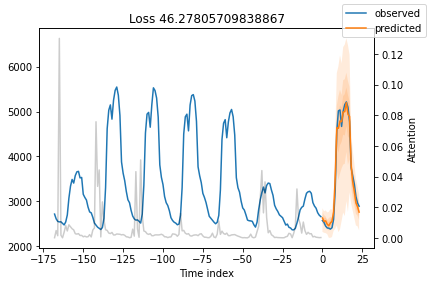

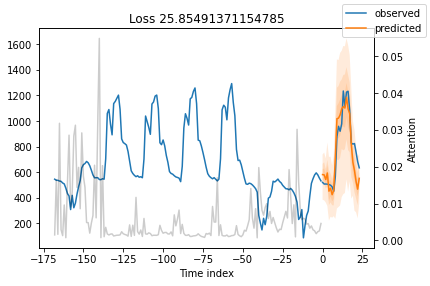

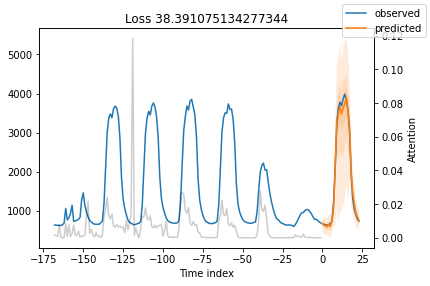

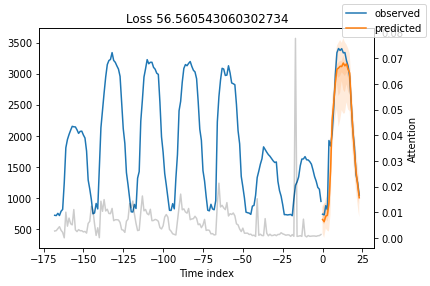

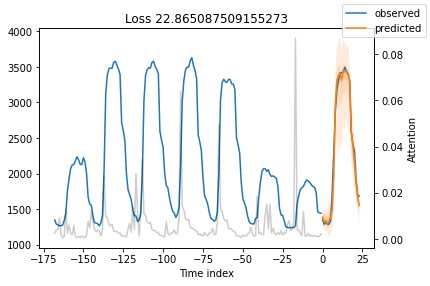

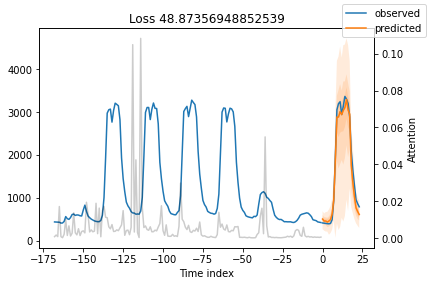

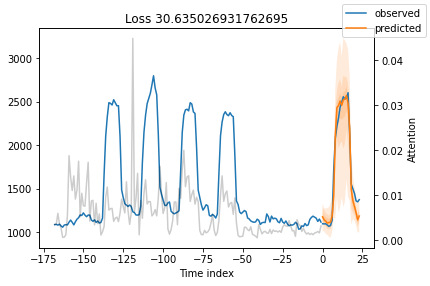

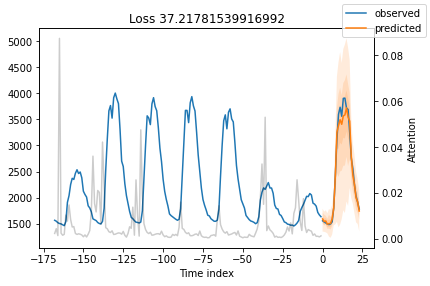

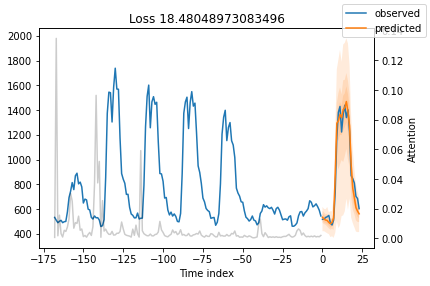

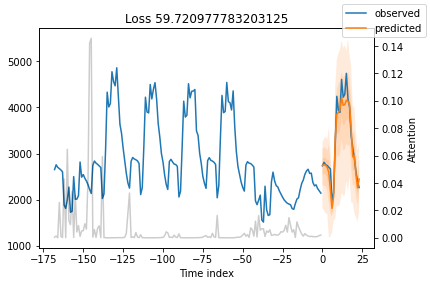

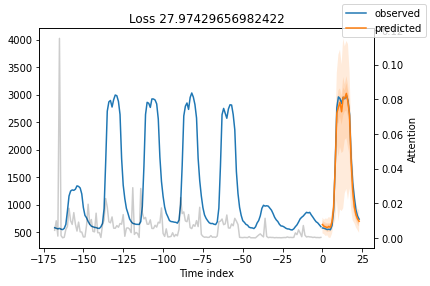

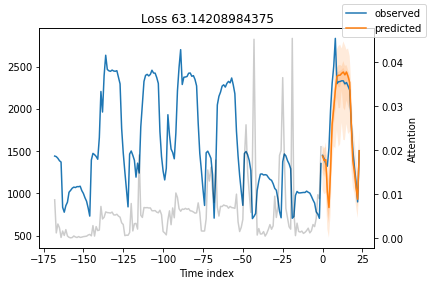

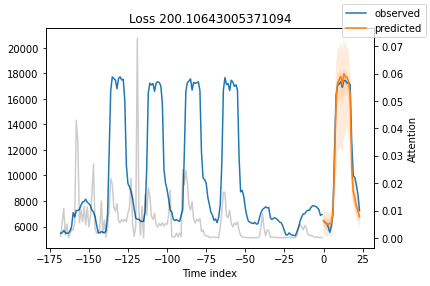

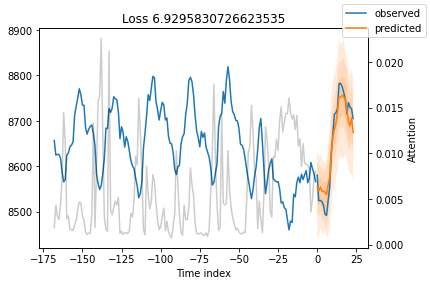

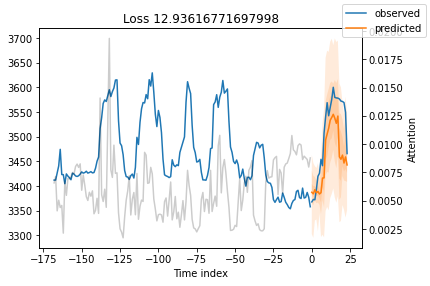

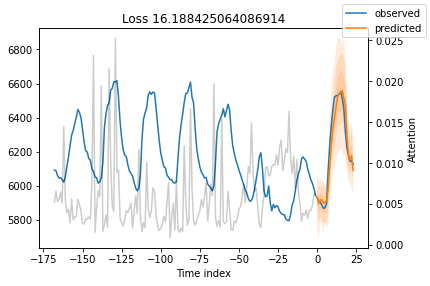

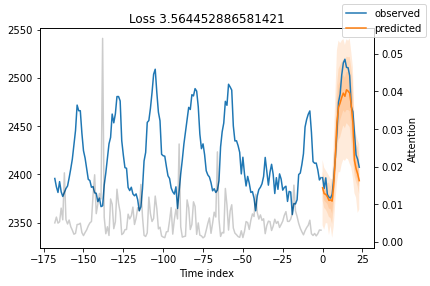

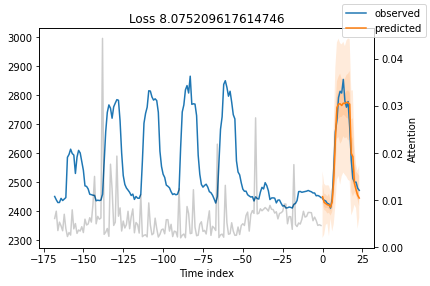

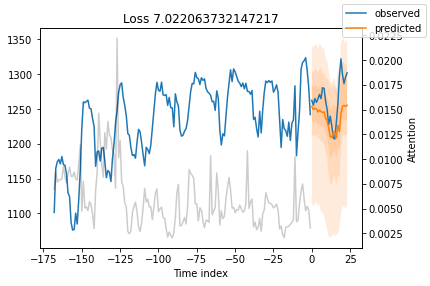

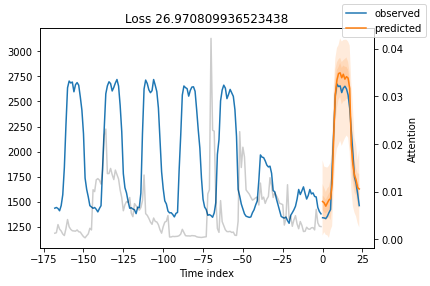

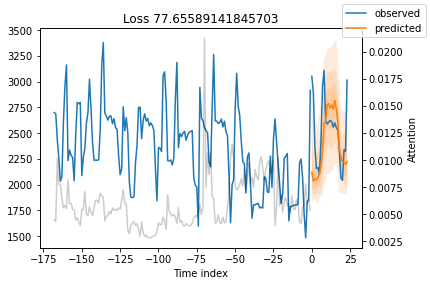

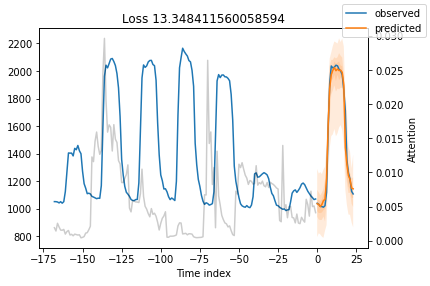

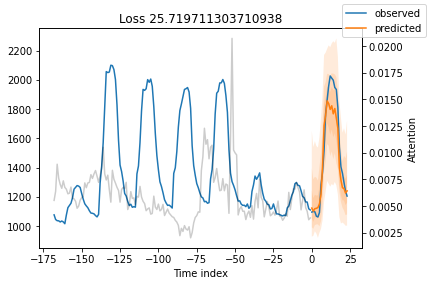

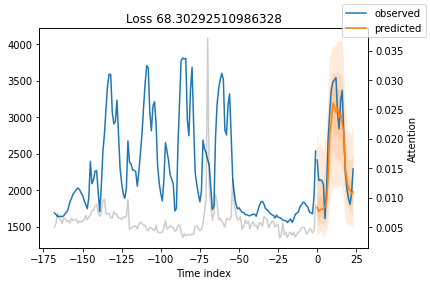

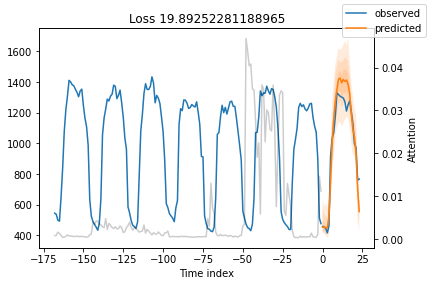

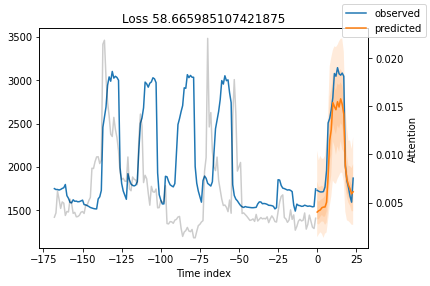

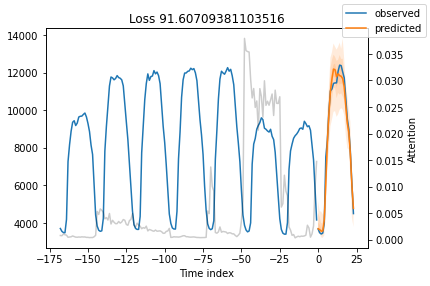

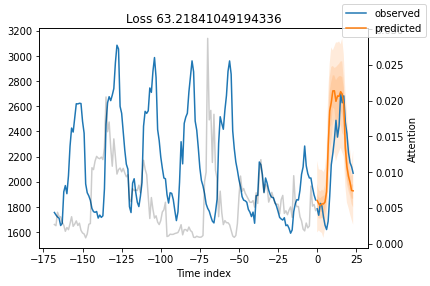

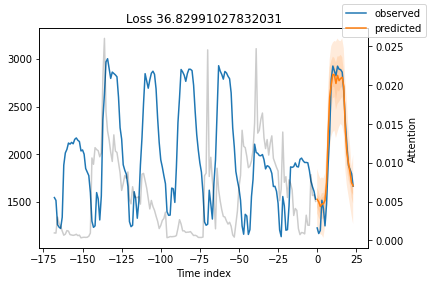

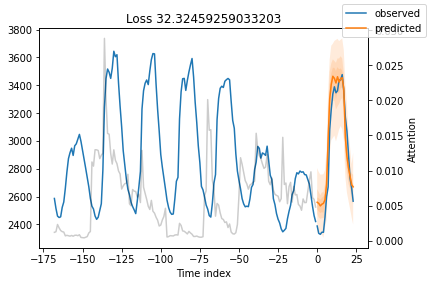

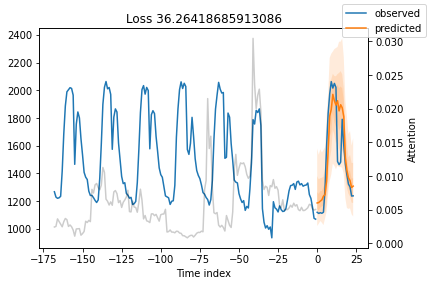

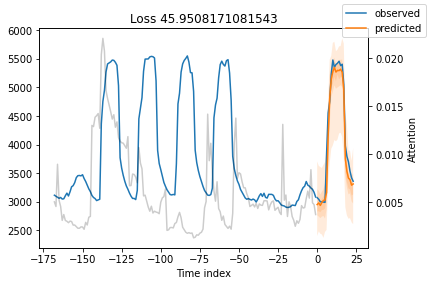

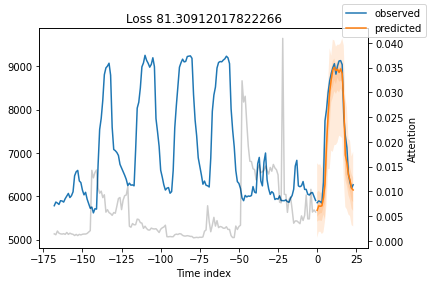

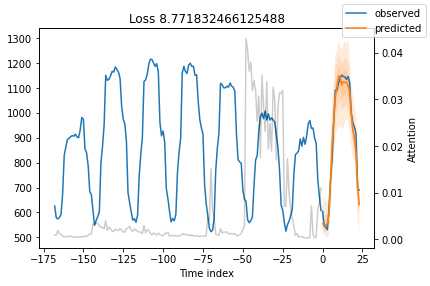

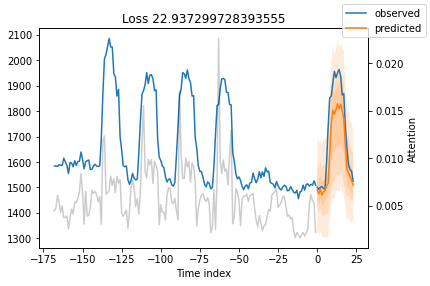

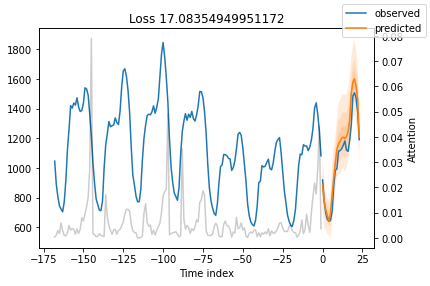

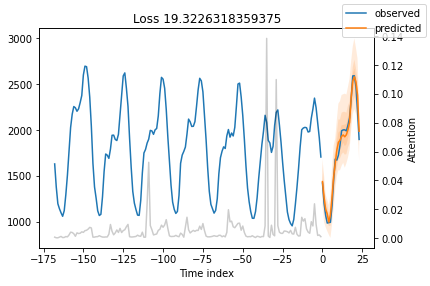

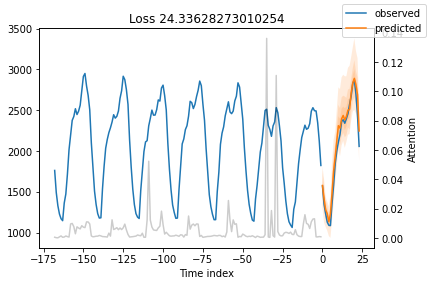

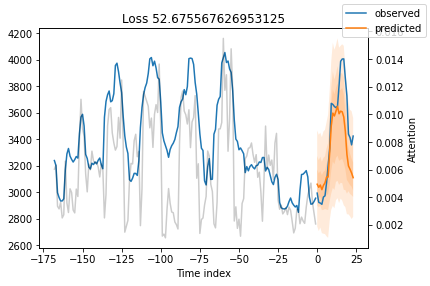

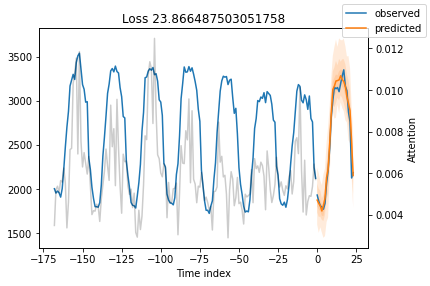

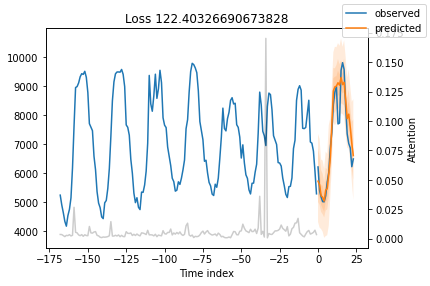

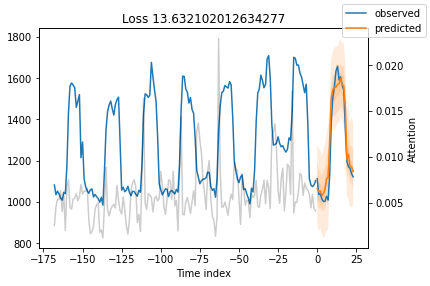

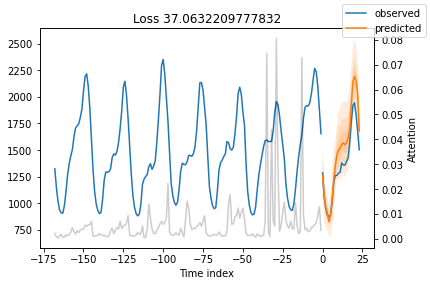

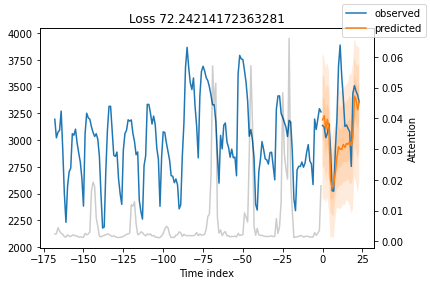

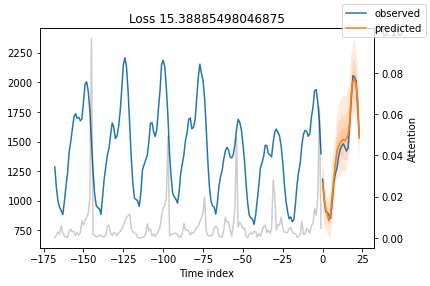

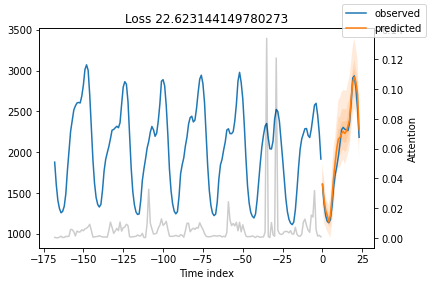

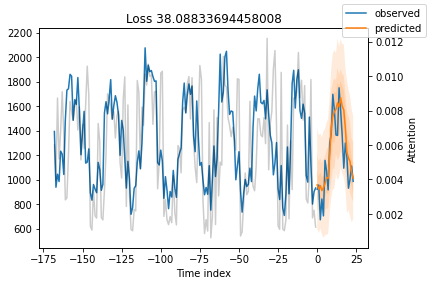

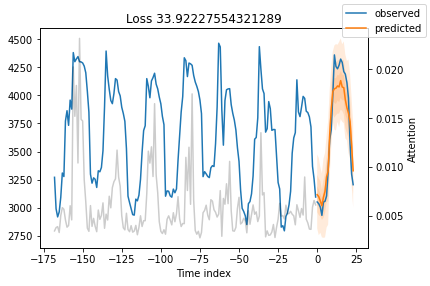

In [6]:
for i in range(len(models)):
    model = models[i]
    print("---------------------- 절취선 ------------------------")
    best_tft, raw_predictions, x = model
    for idx in range(len(group[i])):  # plot 10 examples
        best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)